# Pothole Detection using YOLOv7
* YOLOv7 Tiny model fixed resolution training.

## Dataset:  [Roboflow pothole detection dataset](https://public.roboflow.com/object-detection/pothole/1)
* 1265 training images
* 401 validation images
* 118 test images

In [ ]:
import os
import glob as glob
import matplotlib.pyplot as plt
import random
import cv2

## Download and Extract the Dataset

In [ ]:
# Download the dataset.
!wget https://learnopencv.s3.us-west-2.amazonaws.com/pothole_dataset.zip

--2024-03-21 17:14:24--  https://learnopencv.s3.us-west-2.amazonaws.com/pothole_dataset.zip
Resolving learnopencv.s3.us-west-2.amazonaws.com (learnopencv.s3.us-west-2.amazonaws.com)... 52.92.235.74, 3.5.78.197, 52.92.224.106, ...
Connecting to learnopencv.s3.us-west-2.amazonaws.com (learnopencv.s3.us-west-2.amazonaws.com)|52.92.235.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439133609 (419M) [application/zip]
Saving to: ‘pothole_dataset.zip’

pothole_dataset.zip 100%[===================>] 418.79M  39.4MB/s    in 11s     

2024-03-21 17:14:36 (37.3 MB/s) - ‘pothole_dataset.zip’ saved [439133609/439133609]



In [ ]:
# Extract the dataset.
!unzip -q pothole_dataset.zip

In [ ]:
!ls -l pothole_dataset/images/test

total 26000
-rw-rw-r-- 1 root root 263318 Aug 18  2022 G0010124.JPG
-rw-rw-r-- 1 root root 337312 Aug 18  2022 G0010760.JPG
-rw-rw-r-- 1 root root 409966 Aug 18  2022 G0010770.JPG
-rw-rw-r-- 1 root root 380396 Aug 18  2022 G0011427.JPG
-rw-rw-r-- 1 root root 344510 Aug 18  2022 G0011555.JPG
-rw-rw-r-- 1 root root 382047 Aug 18  2022 G0011563.JPG
-rw-rw-r-- 1 root root 379907 Aug 18  2022 G0011613.JPG
-rw-rw-r-- 1 root root 359967 Aug 18  2022 G0011621.JPG
-rw-rw-r-- 1 root root 382503 Aug 18  2022 G0011759.JPG
-rw-rw-r-- 1 root root 414532 Aug 18  2022 G0011764.JPG
-rw-rw-r-- 1 root root 421099 Aug 18  2022 G0011766.JPG
-rw-rw-r-- 1 root root 449712 Aug 18  2022 G0011775.JPG
-rw-rw-r-- 1 root root 459801 Aug 18  2022 G0011880.JPG
-rw-rw-r-- 1 root root 392695 Aug 18  2022 G0011938.JPG
-rw-rw-r-- 1 root root 319175 Aug 18  2022 G0011953.JPG
-rw-rw-r-- 1 root root 376279 Aug 18  2022 G0016316.JPG
-rw-rw-r-- 1 root root 284054 Aug 18  2022 G0016327.JPG
-rw-rw-r-- 1 root root 290648 Aug 18

## Visualize Images from the Dataset

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))
    all_labels = glob.glob(label_paths)

    all_images.sort()
    all_labels.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_images[j])
        with open(all_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

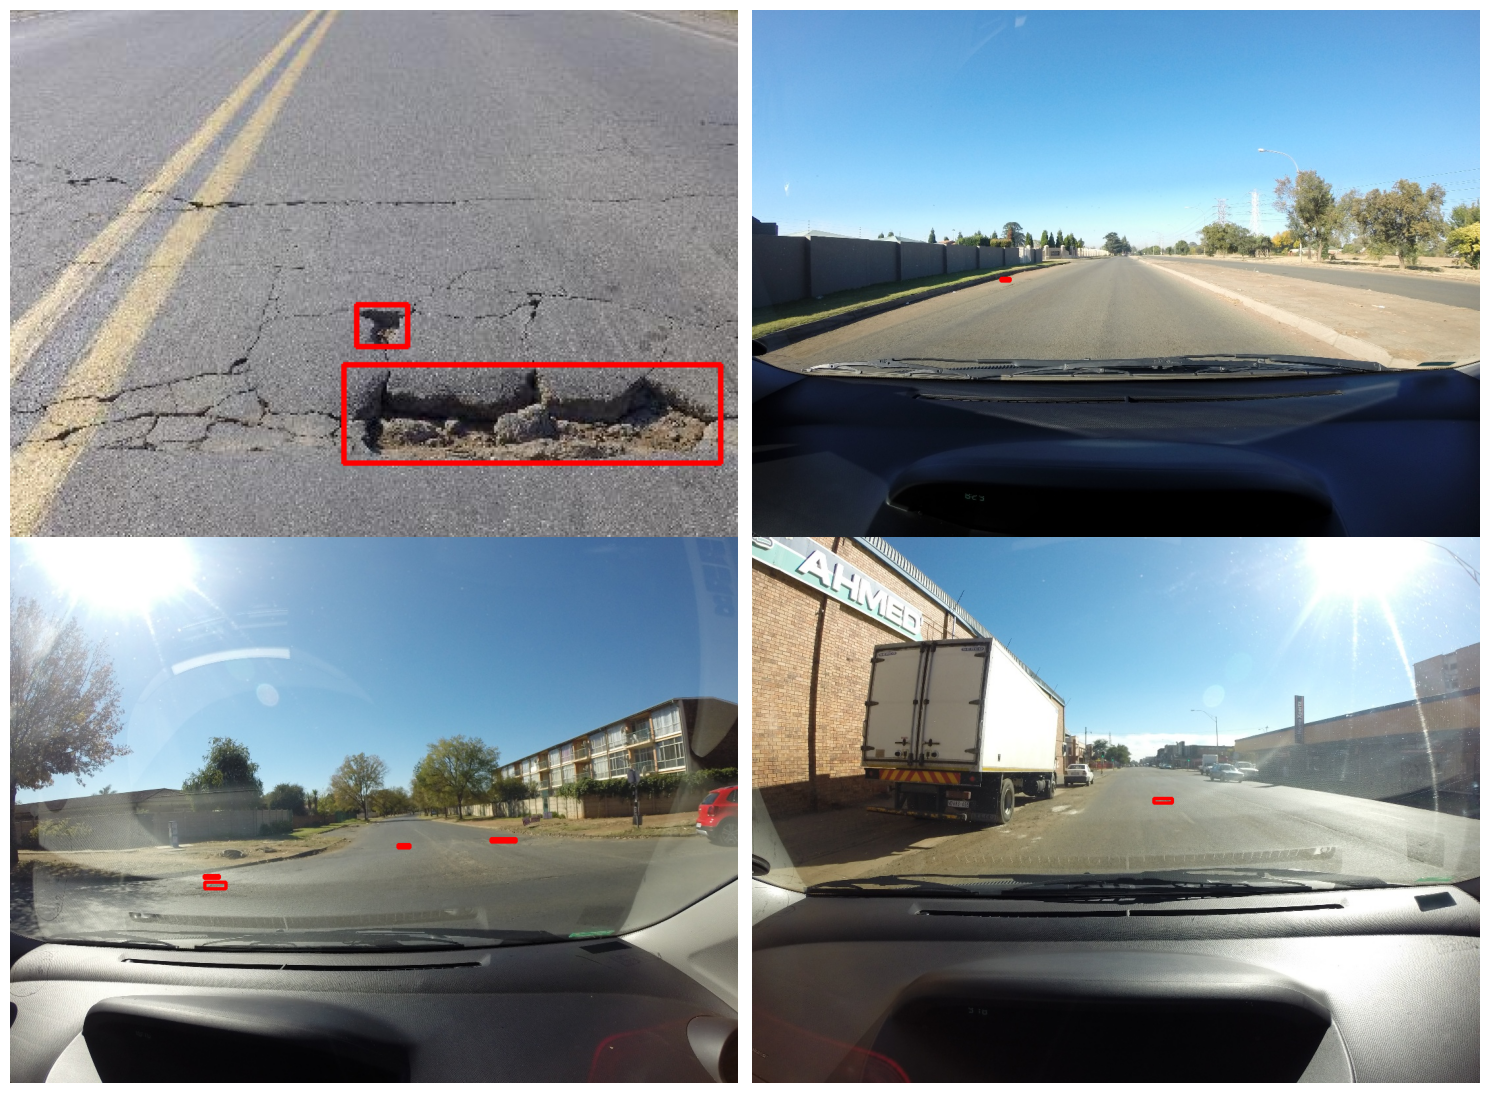

In [ ]:
# Visualize a few training images.
plot(
    image_paths='pothole_dataset/images/train/',
    label_paths='pothole_dataset/labels/train/*.txt',
    num_samples=4,
)

## Repro [YOLOv7](https://github.com/WongKinYiu/yolov7.git)

In [ ]:
if not os.path.exists('yolov7'):
    !git clone https://github.com/WongKinYiu/yolov7.git

In [ ]:
%cd yolov7

In [ ]:
!pip install -r requirements.txt
!pip uninstall wandb -y

## Create the Data YAML File

In [ ]:
%%writefile data/pothole.yaml
train: ../pothole_dataset/images/train
val: ../pothole_dataset/images/valid
test: ../pothole_dataset/images/test

# Classes
nc: 1  # number of classes
names: ['pothole']  # class names

## YOLOv7 Tiny Model Fixed Resolution Training

In [ ]:
# Download the Tiny model weights.
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt

In [ ]:
%%writefile cfg/training/yolov7_pothole-tiny.yaml
# parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# yolov7-tiny backbone
backbone:
  # [from, number, module, args] c2, k=1, s=1, p=None, g=1, act=True
  [[-1, 1, Conv, [32, 3, 2, None, 1, nn.LeakyReLU(0.1)]],  # 0-P1/2

   [-1, 1, Conv, [64, 3, 2, None, 1, nn.LeakyReLU(0.1)]],  # 1-P2/4

   [-1, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 7

   [-1, 1, MP, []],  # 8-P3/8
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 14

   [-1, 1, MP, []],  # 15-P4/16
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 21

   [-1, 1, MP, []],  # 22-P5/32
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [512, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 28
  ]

# yolov7-tiny head
head:
  [[-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, SP, [5]],
   [-2, 1, SP, [9]],
   [-3, 1, SP, [13]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -7], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 37

   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [21, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]], # route backbone P4
   [[-1, -2], 1, Concat, [1]],

   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 47

   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [14, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]], # route backbone P3
   [[-1, -2], 1, Concat, [1]],

   [-1, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 57

   [-1, 1, Conv, [128, 3, 2, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, 47], 1, Concat, [1]],

   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 65

   [-1, 1, Conv, [256, 3, 2, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, 37], 1, Concat, [1]],

   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 73

   [57, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [65, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [73, 1, Conv, [512, 3, 1, None, 1, nn.LeakyReLU(0.1)]],

   [[74,75,76], 1, IDetect, [nc, anchors]],   # Detect(P3, P4, P5)
  ]

## Train Model

In [ ]:
!python train.py --epochs 100 --workers 4 --device 0 --batch-size 32 \
--data data/pothole.yaml --img 640 640 --cfg cfg/training/yolov7_pothole-tiny.yaml \
--weights 'yolov7-tiny.pt' --name yolov7_tiny_pothole_fixed_res --hyp data/hyp.scratch.tiny.yaml

## Test Model

In [ ]:
!python test.py --weights runs/train/yolov7_tiny_pothole_fixed_res/weights/best.pt --task test --data data/pothole.yaml

## Inference

In [ ]:
!python detect.py --weights runs/train/yolov7_tiny_pothole_fixed_res/weights/best.pt --conf 0.25 --img-size 640 --source ../pothole_dataset/images/test/G0010124.JPG

## Show Result

In [ ]:
from IPython.display import Image

In [ ]:
Image(filename='runs/detect/exp/G0010124.JPG')